# Example Usage of Simulation

This file demonstrates the use of rocketPy's simulation environment. 

First we import some useful packages

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as spint

import matplotlib.pyplot as plt


# and from rocket py we need simulation and solutions
from rocketPy.simulation import Simulation as Sim
from rocketPy.solution import Solution

We need a dynamic object to simulate, and we create this using a small class. 

This rocket is a one dimensional object.
We define a few useful properties at creation, but then the functions take over. 

For any dynamic object you need the function ```dynamics```
This function takes in a current time, state, and stage number and returns the rate of change of the state

In addition to this, you can (optionally) define some staging functions. These staging functions define how the dynamic object can change between stages. 

For this example, a simple rocket is modelled. It will thrust upwards, coast, and then descend under a parachute. For simplicity, we only consider the rocket as a one dimensional object. The rocket will return to the ground using dual deployment, ie both a drogue chute and a main chute, each triggered at a different time. 

The drogue chute is deployed 7 seconds after apogee, and (to demonstrate the usage) jumps the position up by 1000m when it happens. This is a very powerful tool, since when staging a rocket you can imagine the mass of rocket to decrease by a step change, which would be difficult to model using other methods. 

The main chute will deploy at an altitude of 2500 m. 

Each of the staging functions have additional properties we need to specify. 

- terminal (boolean): Should the simulation run stop when this event triggers
- direction (1 or -1): which way must the 0-crossing be for the trigger to occur
- etc

In [2]:
class VerySimpleRocket():
    
    def __init__(self):
        self.m = 40
        self.T = 4000
        self.g = 9.81
        self.y0 = np.array([0., 0.])
        self.rhoCDA1 = 0.05
        self.rhoCDA2 = 0.1
        
        self.stage_list = [0,1,2]
        self.staging_functions = [self.staging_deploy_drogue,self.staging_deploy_main, self.staging_landing]
        self.nominal_stages = [0,1,2] # defines this as a nominal flight
        
    def staging_deploy_drogue(self,t,y,stage=0):
        return y[1]
    staging_deploy_drogue.terminal = False
    staging_deploy_drogue.direction=-1
    staging_deploy_drogue.trigger_if_stage_in =[0]
    staging_deploy_drogue.possible_next_stages = [1,2]
    staging_deploy_drogue.nominal_next_stage = 1
    staging_deploy_drogue.t_offset = 7 #stages 7 seconds after the apogee is detected
    staging_deploy_drogue.modify_state = lambda self, state: self.modify_state_drogue_deployed(state)
    
    def staging_deploy_main(self, t, y, stage=0):
        return y[0]-2500
    staging_deploy_main.terminal = False
    staging_deploy_main.direction = -1
    staging_deploy_main.trigger_if_stage_in =[0,1]
    staging_deploy_main.possible_next_stages = [ 2]
    staging_deploy_main.nominal_next_stage = 2
    staging_deploy_main.t_offset = 0
    staging_deploy_main.modify_state = None
    
    def staging_landing(self, t, y, stage=0):
        return y[0]
    staging_landing.terminal = True
    staging_landing.direction = -1
    staging_landing.trigger_if_stage_in =[0,1,2]
    staging_landing.possible_next_stages = []
    staging_landing.nominal_next_stage = None
    staging_landing.t_offset = 0
    staging_landing.modify_state = None
    
    def modify_state_drogue_deployed(self, state):
        
        # this function replaces the state when the corresponding branch is explored
        
        state[0] += 1000
        return state
    
        
    def dynamics(self, t, y, stage=0):

        if stage == 0:
            if t<4:
                return np.array([y[1], self.T/self.m - self.g])
            else:
                return np.array([y[1], -self.g])
                
        elif stage == 1:
            return np.array([y[1], -0.5*self.rhoCDA1*y[1]*abs(y[1])/self.m - self.g])
        
        elif stage == 2:
            return np.array([y[1], -0.5*self.rhoCDA2*y[1]*abs(y[1])/self.m - self.g])
        
        else:
            raise ValueError

Instantiate the rocket and the sim

In [6]:
r = VerySimpleRocket()

In [7]:
s = Simulation(r)

Do a very simple sim, starting at stage 0. 

In [28]:
sol=s.solve([0,600], r.y0, 0, user_events=r.staging_functions)

The result object (from scipy.solve_ivp) is stored in sol.sols, as a list

In [29]:
sol

Solution:
[
 Stages: [0]
 ODEresults: [  message: 'A termination event occurred.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11bde4278>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
       4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10612092e+01])
 t_events: [array([41.57554744]), array([73.97050835]), array([81.06120925])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
         1.19888202e+03,  3.87988823e+03,  2.27373675e-12],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
         3.55698357e+02,  2.71882290e+02, -3.8

Now simulate the nominal trajectory

In [30]:
nominal_sol = s.nominal_solve([0,6000], r.y0, 0)

You can ask for the solution at some time, for instance at $$t = 5$$

In [32]:
nominal_sol.sol(5)

array([1085.70613837,  358.80612043])

so its 1085 m up, with a speed of 358 m/s. 
Or you can plot it

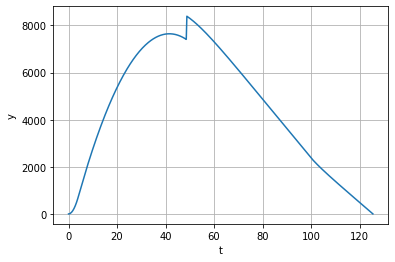

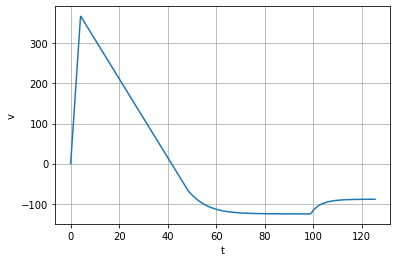

In [37]:
# helper function to get the bounds of the simulation
t_range = np.linspace(nominal_sol.t_min(), nominal_sol.t_max(), 500)

plt.plot(t_range, nominal_sol.sol(t_range)[0])
plt.xlabel('t')
plt.ylabel('y')
plt.grid()

plt.figure()
plt.plot(t_range, nominal_sol.sol(t_range)[1])
plt.xlabel('t')
plt.ylabel('v')
plt.grid()

The real magic is in simulating all possible outcomes

In [16]:
full_sol = s.full_solve([0,6000], r.y0, 0)

full solve gives a list of all the possible simulations

In [44]:
full_sol

[Solution:
 [
  Stages: [0]
  ODEresults: [  message: 'A termination event occurred.'
      nfev: 98
      njev: 0
       nlu: 0
       sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11b3fefd0>
    status: 1
   success: True
         t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
        1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
        4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10612092e+01])
  t_events: [array([41.57554744]), array([73.97050835]), array([81.06120925])]
         y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
          5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
          3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
          1.19888202e+03,  3.87988823e+03,  2.27373675e-12],
        [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
          1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
          2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
          3.55698357e+02,

In [39]:
# number of possible outcomes
len(full_sol)

5

Plot the solutions

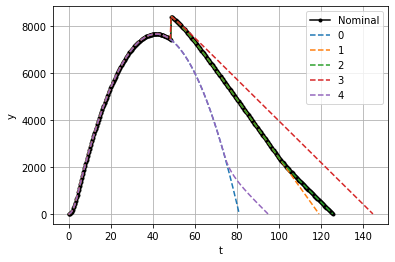

In [54]:

t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[0], '.-k', label='Nominal')


for i, sol in enumerate(full_sol):
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(t_range,sol.sol(t_range)[0], '--',label=i)
    
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

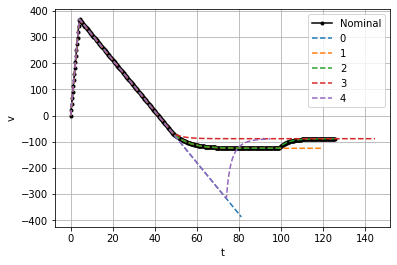

In [55]:
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[1], '.-k', label='Nominal')


for i, sol in enumerate(full_sol):
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(t_range,sol.sol(t_range)[1], '--',label=i)

plt.grid()
plt.xlabel('t')
plt.ylabel('v')
plt.legend()

sometimes its easier to see it in the state space

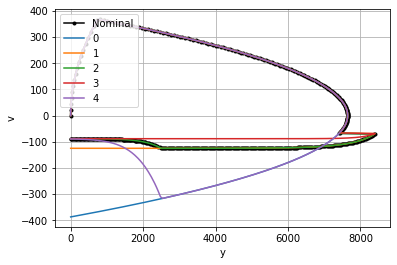

In [56]:
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(nominal_sol.sol(t_range)[0],nominal_sol.sol(t_range)[1], '.-k', label='Nominal')


i=0;
for sol in full_sol:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(sol.sol(t_range)[0],sol.sol(t_range)[1], label=i)
    i+=1
    #plt.xlim([0,50])
plt.grid()
plt.xlabel('y')
plt.ylabel('v')
plt.legend()

or as a list to see what is happening in each

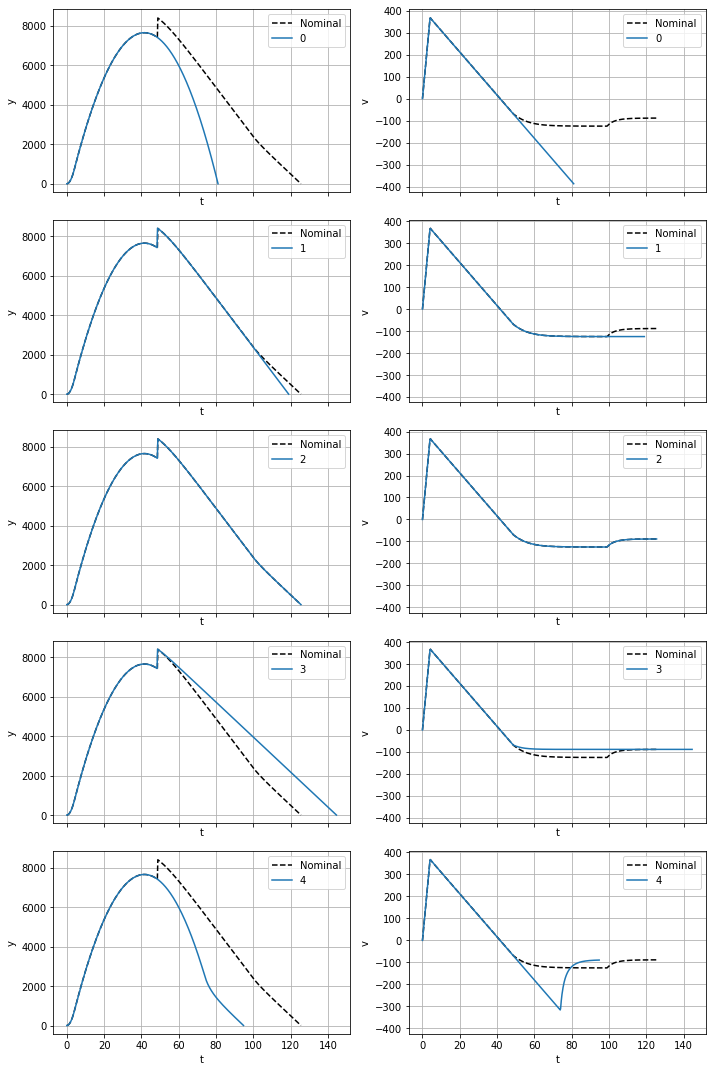

In [57]:
i=0;
fig, axes = plt.subplots(len(full_sol),2, sharex='col', sharey='col', figsize=(10,15), squeeze=False)
for sol in full_sol:
    
    t_range_nom = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
    axes[i][0].plot(t_range_nom,nominal_sol.sol(t_range_nom)[0], '--k', label='Nominal')
    axes[i][1].plot(t_range_nom,nominal_sol.sol(t_range_nom)[1], '--k', label='Nominal')
    
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    axes[i][0].plot(t_range,sol.sol(t_range)[0], label=i)
    axes[i][1].plot(t_range,sol.sol(t_range)[1], label=i)
    
    axes[i][0].grid(True)
    axes[i][0].set_xlabel('t')
    axes[i][0].set_ylabel('y')
    axes[i][0].legend()
    
    axes[i][1].grid(True)
    axes[i][1].set_xlabel('t')
    axes[i][1].set_ylabel('v')
    axes[i][1].legend()
    i+=1
    
plt.tight_layout()
